<a href="https://colab.research.google.com/github/juanmadlg/K-armed-Bandit-Problem/blob/main/K_Armed_Testbed_and_the_Step_Size_Effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### K-armed Testbed

"*The multi-armed bandit problem (sometimes called the K-armed or N-armed bandit problem) is a problem in which a fixed limited set of resources must be allocated between competing (alternative) choices in a way that maximizes their expected gain, when each choice's properties are only partially known at the time of allocation, and may become better understood as time passes or by allocating resources to the choice. This is a classic reinforcement learning problem that exemplifies the exploration–exploitation tradeoff dilemma.*"

--- [Wikipedia](https://en.wikipedia.org/wiki/Multi-armed_bandit) 

In this Notebook I'm going to review the Step Size Effect in the Value-Function update. 

This is the previous implementation
 
> Q(A) = Q(A) + (R - Q(A)) / N(A)
> <=>
> Q(A) = Q(A) + StepSize * (R - Q(A)) where StepSize = 1/N(A)


I'm going to play and compare different Step Sizes.

The agent will select the actions following the epislon-greedy policy.

**Note:** This Notebook has been created in Google Colab.

## Packages

You will use the following packages in this assignment.

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.

In [1]:
!pip install jdc

In [2]:
# Imports
import numpy as np
import jdc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## K-Arms Class

These are the elements included in the K-Arms Class
* **k**: The number of Arms
* **Q**: It stores the Function Values for each Arm. Vector of size (k, )
* **A**: It stores the number of 'executions' of the specific Arm. Vector of size (k, ). Initializated each time 'reset' is executed.
* **arms_mean**: Mean for the distribution of the Q* for each Arm
* **standard_deviation**: It is used in two cases: 
  * To generate the random distribution of the Q* for each Arm 
  * To generate the random value of an Arm when it is executed (using the on the Q* of the arm as a mean).
* **e**: Epsilon for action selection

In [3]:
class k_armed:
  def __init__(self, configuration):
    '''
    Configuration is a dictionary that includes all diferente required settings
    '''
    self.Q = None
    self.N = None
    self.A = None
    self.k = configuration['k'] # Number of Arms
    self.e = configuration['e']
    self.step_size = configuration['step_size']

    self.arms_mean = configuration['arms_mean']
    self.standard_deviation = configuration['std_dev'] # For Arms Distribution and Arms values

  def reset(self):
    '''
    Reset is executed at the begining of each episode. It sets to 0 Q and N
    and creates a new distribution of Q* for the k arms.
    '''
    self.Q = np.zeros((self.k,))
    self.N = np.zeros((self.k,))
    self.A = np.random.normal(loc=self.arms_mean, scale=self.standard_deviation, size=(self.k,))

### Episilon-greedy action selection



In [4]:
%%add_to k_armed

def get_action(self):
  '''
  €-greedy action selection: exploration vs. exploitation
  '''
    
  if np.random.random_sample() <= self.e:
    return np.random.randint(self.k) # Exploration

  return np.argmax(self.Q) # Exploitation

### Bandit

Returns a random value in a normal distribution with Q*(arm) and the standard_deviation

In [5]:
%%add_to k_armed

def bandit(self, a):
  '''
  Gets value of the selected arm based on a normal distribution with Q*(a) as the mean
  '''
  return np.random.normal(self.A[a], self.standard_deviation)

### k-armed Execution

For each step:
* Get the Action (Arm) (€-greedy action selection).
* Get the Value (Reward) for that Arm.
* Increment the number of Steps.
* Calculate the Value Function for the Arm:
  * If step_size is 'N' the Value-Function the step size will be the inverse of the number of times that action has been executed.
  * Elsewhere the number set as step_size.

In [6]:
%%add_to k_armed

def exec(self, steps):
  self.reset()

  rewards = []
  for i in range(steps):
    A = self.get_action()
    R = self.bandit(A)

    self.N[A] += 1

    # New Code for Step Size Effect
    if self.step_size == 'N':
      self.Q[A] = self.Q[A] + (R - self.Q[A]) / self.N[A] 
    else:
      self.Q[A] = self.Q[A] + self.step_size * (R - self.Q[A])

    rewards.append(R)

  return rewards

## Evaluate the Rewards

### Evaluate different Step Sizes y Epsilon values

To evaluate the different values of step sizes and epsilon values we are going to execute N different runs an calculate the average for each step.

In [16]:
def evaluate(configuration, experiments, steps, runs):
  rewards = []
  
  # For these three epsilon values
  for epsilon, step_size in experiments:
    print(f'Execution {runs} runs with epsilon: {epsilon}, and step size: {step_size}')
    configuration['e'] = epsilon
    configuration['step_size'] = step_size

    e_k_armed = k_armed(configuration)
    epsilon_rewards = np.zeros((steps, ))
  
    # Lets execute son independent runs
    for i in tqdm(range(runs)):
      epsilon_rewards = np.add(epsilon_rewards, e_k_armed.exec(steps))
  
    # Average for each step
    rewards.append(epsilon_rewards / runs)
  
  return rewards

In [17]:
# Each tuple represents and epsilon_value, step_size
experiments = [[0.01, 'N'], [0.1, 'N'], [0.5, 'N'], [0.01, 0.1], [0.1, 0.1], [0.5, 0.1], [0.01, 0.5], [0.1, 0.5], [0.5, 0.5]]

configuration = {
    'k': 10,
    'e': None,
    'step_size': None,
    'arms_mean': 1,
    'std_dev': 1
}

steps = 800
runs = 2000

rewards = evaluate(configuration, experiments, steps, runs)

Execution 2000 runs with epsilon: 0.01, and step size: N



Execution 2000 runs with epsilon: 0.1, and step size: N



Execution 2000 runs with epsilon: 0.5, and step size: N



Execution 2000 runs with epsilon: 0.01, and step size: 0.1



Execution 2000 runs with epsilon: 0.1, and step size: 0.1



Execution 2000 runs with epsilon: 0.5, and step size: 0.1



Execution 2000 runs with epsilon: 0.01, and step size: 0.5



Execution 2000 runs with epsilon: 0.1, and step size: 0.5



Execution 2000 runs with epsilon: 0.5, and step size: 0.5


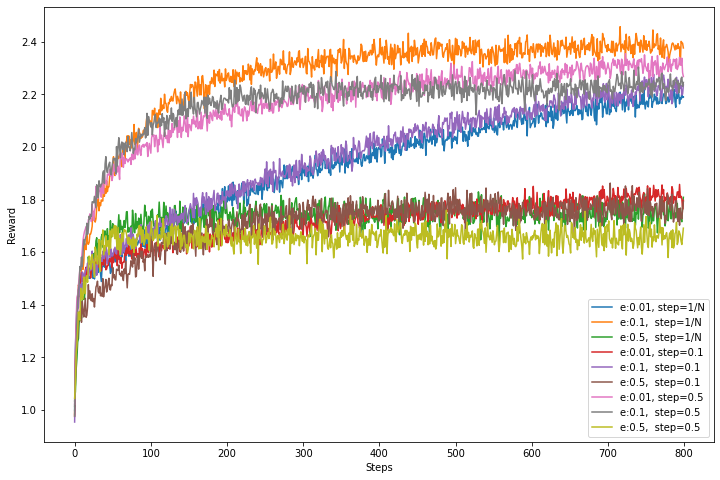

In [18]:
plt.figure(figsize=(12,8))
plt.plot(range(steps), rewards[0], label='e:0.01, step=1/N')
plt.plot(range(steps), rewards[1], label='e:0.1,  step=1/N')
plt.plot(range(steps), rewards[2], label='e:0.5,  step=1/N')
plt.plot(range(steps), rewards[3], label='e:0.01, step=0.1')
plt.plot(range(steps), rewards[4], label='e:0.1,  step=0.1')
plt.plot(range(steps), rewards[5], label='e:0.5,  step=0.1')
plt.plot(range(steps), rewards[6], label='e:0.01, step=0.5')
plt.plot(range(steps), rewards[7], label='e:0.1,  step=0.5')
plt.plot(range(steps), rewards[8], label='e:0.5,  step=0.5')
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

### Conclusions

It is interesting to see the results. 
* Epsilon greedy of 0.1 has a good performance for almost any step size. 
* Epsilon value seems to affect more in the performance than the step size for our problem.
* As a curiosity the performance of the combination epsilon = 0.01 and step size = 0.5. 